In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import radical.pilot as rp
import radical.utils as ru
import radical.analytics as ra
from radical.entk import Profiler
import numpy as np
from math import sqrt
import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
FONTSIZE = SIZE
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y))
    
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
        for ax1 in axes:
            for ax2 in ax1:
                ax2.get_xaxis().tick_bottom()  
                ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
def task_executable():
    
    num_x = 1
    num_y = 1
    fig, axis = fig_setup(num_x, num_y, (10*num_x,6*num_y))
    axis = axis[0][0]
    
    df = pd.DataFrame(columns=[512,1024,2048,4096])
    df.loc['executable-A'] = [5,5,5.5,10]
    df.loc['executable-B'] = [5,5,5.5,10]
    df.loc['executable-C'] = [5,5,5.5,10]
    
    ax = df.plot(    kind='bar',
                     ax=axis,
                     fontsize=FONTSIZE,
#                      legend=True,
                     legend=False,
                     ylim=(0,20),
                     rot=0,
#                      title=     'Time taken by EnTK and RP to execute three applications with task-\n'+ 
#                                 'count adaptivity, Workflow: 1 Pipeline, L Stages per Pipeline and 1\n'+
#                                 'Task per Stage, Resource: XSEDE.SuperMIC, Task kernel = X, Task\n'+
#                                 'duration = 0 second(s), Number of trials per data point = 5'
                                )
    
    ax.set_xlabel('Application executable', fontsize=FONTSIZE)
    ax.set_ylabel('Adaptivity Overhead (seconds)', fontsize=FONTSIZE)
    ax.set_title(ax.get_title(), fontsize=FONTSIZE)
    
    handles, l1 = ax.get_legend_handles_labels()
    labels = []
    for l in l1:
        labels.append (l + ' stages')
    
    plt.legend(handles,labels,fontsize=FONTSIZE, loc='best', bbox_to_anchor=(1.0,1.0))
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_executable_without_title.pdf', dpi=100, bbox_inches='tight')
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_executable_without_title.png', dpi=100, bbox_inches='tight')
    #plt.gca().set_xlim([-1.,1.5])        

In [5]:
def target_resource():
    
    num_x = 1
    num_y = 1
    fig, axis = fig_setup(num_x, num_y, (10*num_x,6*num_y))
    axis = axis[0][0]
    
    df = pd.DataFrame(columns=[512,1024,2048,4096])
    df.loc['SuperMIC'] = [5,5,5.5,10]
    df.loc['Comet'] = [5,5,5.5,10]
    df.loc['Stampede'] = [5,5,5.5,10]
    df.loc['Titan'] = [2.5,2.5,2.75,5]
    
    ax = df.plot(    kind='bar',
                     ax=axis,
                     fontsize=FONTSIZE,
#                      legend=True,
                     legend=False,
                     ylim=(0,20),
                     rot=0,
#                      title=     'Time taken by EnTK and RP to execute four applications with task-\n'+ 
#                                 'count adaptivity, Workflow: 1 Pipeline, L Stages per Pipeline and\n'+
#                                 '1 Tasks per Stage, Resource: [SuperMIC, Comet, Stampede, Titan],\n'+
#                                 'Task kernel = sleep, Task duration = 0 second(s),\n'+
#                                 'Number of trials per data point = 5'
                )
    
    ax.set_xlabel('Target Resource', fontsize=FONTSIZE)
    ax.set_ylabel('Adaptivity Overhead (seconds)', fontsize=FONTSIZE)
    ax.set_title(ax.get_title(), fontsize=FONTSIZE)
    
    handles, l1 = ax.get_legend_handles_labels()
    labels = []
    for l in l1:
        labels.append (l + ' stages')
    
    plt.legend(handles,labels,fontsize=FONTSIZE, loc='best', bbox_to_anchor=(1.0,1.0))
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_resource_without_title.pdf', dpi=100, bbox_inches='tight')
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_resource_without_title.png', dpi=100, bbox_inches='tight')
    #plt.gca().set_xlim([-1.,1.5])     

In [6]:
def task_cps():
    
    num_x = 1
    num_y = 1
    fig, axis = fig_setup(num_x, num_y, (10*num_x,6*num_y))
    axis = axis[0][0]
    
    df = pd.DataFrame(columns=[512,1024,2048,4096])
    df.loc['1'] = [5,5,5.5,10]
    df.loc['2'] = [5,5,5.5,10]
    df.loc['4'] = [5,5,5.5,10]
    df.loc['8'] = [2.5,2.5,2.75,5]
    
    ax = df.plot(    kind='bar',
                     ax=axis,
                     fontsize=FONTSIZE,
#                      legend=False,
                     ylim=(0,20),
                     rot=0,
#                      title=     'Time taken by EnTK and RP to execute four applications with task-\n'+ 
#                                 'count adaptivity, Workflow: 1 Pipeline, L Stages per Pipeline and\n'+
#                                 '1 Tasks per Stage, Resource: SuperMIC, Task kernel = Gromacs, Task\n'+
#                                 'duration = 250 second(s) on 1 core, Cores per Task = X,\n'+
#                                 'Number of trials per data point = 5'
                                )
    
    ax.set_xlabel('Cores per task', fontsize=FONTSIZE)
    ax.set_ylabel('Adaptivity Overhead (seconds)', fontsize=FONTSIZE)
    ax.set_title(ax.get_title(), fontsize=FONTSIZE)
    
    handles, l1 = ax.get_legend_handles_labels()
    labels = []
    for l in l1:
        labels.append (l + ' stages')
    
    plt.legend(handles,labels,fontsize=FONTSIZE, loc='best', bbox_to_anchor=(1.0,1.0))
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_cps_without_title.pdf', dpi=100, bbox_inches='tight')
    fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_cps_without_title.png', dpi=100, bbox_inches='tight')
    #plt.gca().set_xlim([-1.,1.5])     

In [36]:
def task_duration():
    
    num_x = 1
    num_y = 1
    fig, axis = fig_setup(num_x, num_y, (10*num_x,6*num_y))
    axis = axis[0][0]
    data_loc = '../raw_data/task-dur/'
    dur = [60,120]
    stages = [1,2,4,8,16,32]
    
    df = pd.DataFrame(columns=stages)
    for d in dur:
        tte_list = list()
        for s in stages[:6]:
            json_files = glob.glob('{0}/dur-{1}-addstages-{2}/rp.*/*.json'.format(data_loc, d, s))
            json_file = json_files[0]
            json      = ru.read_json(json_file)
            sid       = os.path.basename(json_file)[:-5]
            mongo     = json['pilot'][0]['cfg']['dburl']
            os.environ['RADICAL_PILOT_DBURL'] = mongo

            session = ra.Session(stype='radical.pilot', src='{0}/dur-{1}-addstages-{2}/{3}'.format(data_loc, d, s, sid))
            units = session.filter(etype='unit', inplace=False)
            pilots   = session.filter(etype='pilot', inplace=False)
            
#             print 'Stages: ',s,' Duration: ',d,' Time: ', units.duration(event=[{ru.EVENT: 'exec_start'},
#             {ru.EVENT: 'exec_stop'}]), units.duration([rp.AGENT_EXECUTING, rp.FINAL])
            tte_list.append(units.duration(event=[  {ru.EVENT: 'exec_start'},
                                                    {ru.EVENT: 'exec_stop'}]))

        df.loc[d] = tte_list
        
    ax = df.plot(    kind='bar',
                     ax=axis,
                     fontsize=FONTSIZE,
#                      ylim=(0,20),
                     rot=0,
#                      title=     'Time taken by EnTK and RP to execute four applications with task-\n'+ 
#                                 'count adaptivity, Workflow: 1 Pipeline, L Stages per Pipeline and\n'+
#                                 '1 Tasks per Stage, Resource: SuperMIC, Task kernel = Gromacs, Task\n'+
#                                 'duration = 250 second(s) on 1 core, Cores per Task = X,\n'+
#                                 'Number of trials per data point = 5'
                                )
    
    ax.set_xlabel('Stress duration (seconds)', fontsize=FONTSIZE)
    ax.set_ylabel('Task Execution Time (seconds)', fontsize=FONTSIZE)
    ax.set_title(ax.get_title(), fontsize=FONTSIZE)
    
    handles, l1 = ax.get_legend_handles_labels()
    labels = []
    for l in l1:
        labels.append (l + ' stages')
    
#     plt.legend(handles,labels,fontsize=FONTSIZE, loc='best', bbox_to_anchor=(1.0,1.0))
    plt.legend(handles,labels,fontsize=FONTSIZE, loc='best')
    fig.savefig('../plots/entk_task_count_adaptivity_exec_dur_without_title.pdf', dpi=100, bbox_inches='tight')
    fig.savefig('../plots/entk_task_count_adaptivity_exec_dur_without_title.png', dpi=100, bbox_inches='tight')

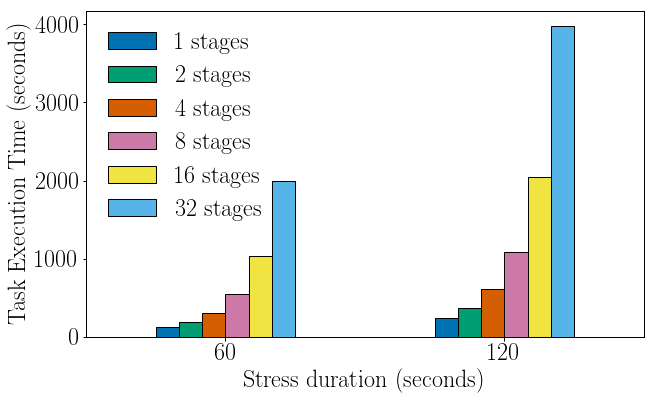

In [37]:
# num_x = 2
# num_y = 2
# fig, axes = fig_setup(num_x, num_y, (10*num_x,6*num_y))
# task_executable()
task_duration()
# target_resource()
# task_cps()

# fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_without_title.pdf', dpi=100, bbox_inches='tight')
# fig.savefig('../plots/pseudoplots/entk_task_count_adaptivity_without_title.png', dpi=100, bbox_inches='tight')